In [94]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
from scipy import stats
from scipy.optimize import minimize

from itertools import combinations

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.class_weight import compute_class_weight

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

import tensorflow as tf  # another kernel: work in progress - MLP with BatchNorm, Convolutional

from utils import *
import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

ID_COL = 'APPLICATION_NUMBER'
TARGET= 'TARGET'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**models based on profile data**

In [103]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    if df[col].nunique() > 20:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str).fillna("NA"))
df, _ = get_encoded(df)

data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]

X = X.drop(ID_COL, axis=1)

X.shape
# pay attention at EXTERNAL_WEIGHTED_SCORE: lots of NA values due to NA in additive terms (next hypothesis to fillna(0) in sum)

Memory usage of dataframe is 182.15 MB
Memory usage after optimization is: 86.31 MB
Decreased by 52.6%


(110093, 117)

In [5]:
# features, selected by BorutaShap and handy elimination
boruta = ['NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AGE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 
          'DAYS_ON_LAST_JOB', 'ANNUITY_JOB', 'RATIO_CREDIT_TO_AGE', 'RATIO_CAR_TO_EXPERIENCE', 'RATIO_CAR_TO_AGE', 
          'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SALARY_JOB', 
          'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_3', 
          'NAME_CONTRACT_TYPE', 'CREDIT_JOB', 'AMOUNT_CREDIT', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 
          'EXTERNAL_SCORE_WEIGHTED', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'EXTERNAL_SCORING_RATING_2', 
          'EDUCATION_FAMILY_STATUS', 'GENDER', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
          'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'AMOUNT_ANNUITY', 'OWN_CAR_AGE', 'RATIO_AGE_TO_EXPERIENCE', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EXTERNAL_SCORING_RATING_1', 
          'TOTAL_SALARY_COUNT_BY_EDUCATION', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 
          'RATIO_SALARY_TO_AGE', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'AMT_REQ_CREDIT_BUREAU_QRT', 
          'SALARY_REGION_POPULATION', 'AGE_BIN', 'TOTAL_SALARY_MAX_BY_EDUCATION', 'NEW_STATUS_FMarried', 
          'RATIO_SALARY_TO_AMOUNT_CREDIT']

**LGBM Base model (boruta features from profile.csv)**

Predictions for test are obtained by averaging CV estimators

In [337]:
# got 0.73211 on LB
lgbm_params_my = {  # initial params
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 42,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

adv_params = {
              'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 2000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.7,
              'min_split_gain': 0.024766,
              'min_child_weight': 56,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.508716,
              'is_unbalance': False,
              'random_state': seed,
              'learning_rate': 0.06922946617835303,
              'max_depth': 10,
              'min_child_weight': 129,
              'num_leaves': 18
}

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(adv_params, 
                                                            X[boruta], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=50)

Tue Aug 30 16:05:30 2022, Cross-Validation, 110093 rows, 42 cols
Fold 1, Train score = 0.75245, Valid score = 0.74478
Fold 2, Train score = 0.76315, Valid score = 0.72618
Fold 3, Train score = 0.74952, Valid score = 0.72751
Fold 4, Train score = 0.76255, Valid score = 0.73424
Fold 5, Train score = 0.75703, Valid score = 0.71899
Train score by each fold: [0.75245, 0.76315, 0.74952, 0.76255, 0.75703]
Valid score by each fold: [0.74478, 0.72618, 0.72751, 0.73424, 0.71899]
Train mean score by each fold:0.75694 +/- 0.00539
Valid mean score by each fold:0.73034 +/- 0.00869
**************************************************
OOF-score: 0.72938


In [338]:
# this is no quite fair as we used oof values for early stopping in CV loop. CI would be optimistic
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm, roc_auc_score))

(0.7239391739589673, 0.7351757815515385)

In [339]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_lgbm])
# test_preds1 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds1 = test_preds.T.mean(axis=1)

**CatBoost Base model**

In [9]:
# 0.72989
cat_params = { # initial params
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 1000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                #'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.839,  
                'depth': 6, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,  
}
cat_cols = [column for column in X.columns if X[column].dtype in ["object", "category"]]
# there are no cat features as they all were encoded earlier. Which is not recommended by catboost developers
estimators_cat, oof_preds_cat = catboost_cross_validation(cat_params, 
                                                          X[boruta], 
                                                          y, 
                                                          cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                          rounds=50)

Mon Aug 29 01:19:26 2022, Cross-Validation, 110093 rows, 42 cols
Fold 1, Train score = 0.75819, Valid score = 0.74345
Fold 2, Train score = 0.75763, Valid score = 0.72580
Fold 3, Train score = 0.75460, Valid score = 0.72823
Fold 4, Train score = 0.75738, Valid score = 0.72935
Fold 5, Train score = 0.76206, Valid score = 0.71923
Train score by each fold: [0.75819, 0.75763, 0.7546, 0.75738, 0.76206]
Valid score by each fold: [0.74345, 0.7258, 0.72823, 0.72935, 0.71923]
Train mean score by each fold:0.75797 +/- 0.00239
Valid mean score by each fold:0.72921 +/- 0.00794
**************************************************
OOF-score: 0.72831


In [10]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat, roc_auc_score))

(0.7230139582496385, 0.7335391322984915)

In [11]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_cat])
# test_preds2 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds2 = test_preds.T.mean(axis=1)

**Add Bureau features and new models**

In [12]:
bureau = bki_cr()
bureau.shape

(273131, 34)

In [13]:
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X = X.merge(bureau, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [ ]:
# select informative features with less overfitting params
lgbm_params = { 
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 212, 
                'learning_rate': 0.01, 
                'min_child_weight': 350, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

In [14]:
boruta_bureau = ['EXTERNAL_SCORE_WEIGHTED', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'DAYS_ON_LAST_JOB', 
                 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'ANNUITY_JOB', 
                 'EXTERNAL_SCORING_RATING_2', 'AMOUNT_CREDIT', 'EXTERNAL_SCORING_RATING_3', 'AGE', 'AMOUNT_ANNUITY', 
                 'AMT_REQ_CREDIT_BUREAU_YEAR', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'RATIO_SALARY_TO_AGE', 
                 'EXTERNAL_SCORING_RATING_1', 'EXT_SCORE_3_ANNUITY', 'EXT_SCORE_3_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
                 'EXT_SCORE_2_ANNUITY', 'GENDER', 'EDUCATION_LEVEL_Higher education', 'EXT_SCORE_2_AMT_CREDIT', 
                 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
                 'OWN_CAR_AGE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'EDUCATION_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE', 
                 'NEW_STATUS_FMarried', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 'CREDIT_JOB',
                 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 
                 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'RATIO_CAR_TO_EXPERIENCE', 'NEW_CREDIT_TO_ANNUITY_RATIO', 
                 'RATIO_ANNUITY_TO_AGE', 'NAME_CONTRACT_TYPE', 'RATIO_AGE_TO_EXPERIENCE', 
                 'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'SALARY_JOB', 
                 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 
                 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_MAX_BY_EDUCATION', 
                 'AMOUNT_ANNUITY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_MAX_AGE_INTERVAL', 'AGE_BIN', 'REGION_POPULATION', 
                 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'BURO_CREDIT_TYPE_Consumer credit_MEAN']

**LGBM model 2**

In [346]:
# 0.73209
lgbm_params_my = {  # initial params
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 42,
    'max_depth': 5,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

adv_params = {'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 2000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.7,
              'min_split_gain': 0.024766,
              'min_child_weight': 56,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.508716,
              'is_unbalance': False,
              'random_state': seed,
              'learning_rate': 0.022145586882939203,
              'max_depth': 12,
              'min_child_weight': 92,
              'num_leaves': 28
             }
    
estimators_lgbm2, oof_preds_lgbm2 = lightgbm_cross_validation(adv_params, 
                                                              X[boruta_bureau], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//2, shuffle=True), 
                                                              rounds=50)

Tue Aug 30 20:27:32 2022, Cross-Validation, 110093 rows, 56 cols
Fold 1, Train score = 0.76069, Valid score = 0.72400
Fold 2, Train score = 0.77439, Valid score = 0.73674
Fold 3, Train score = 0.76865, Valid score = 0.72287
Fold 4, Train score = 0.77386, Valid score = 0.73067
Fold 5, Train score = 0.77367, Valid score = 0.73574
Train score by each fold: [0.76069, 0.77439, 0.76865, 0.77386, 0.77367]
Valid score by each fold: [0.724, 0.73674, 0.72287, 0.73067, 0.73574]
Train mean score by each fold:0.77025 +/- 0.00521
Valid mean score by each fold:0.73000 +/- 0.00576
**************************************************
OOF-score: 0.72969


In [347]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm2, roc_auc_score))

(0.7243578415113249, 0.734969255962553)

In [348]:
preds = pd.DataFrame(data=np.array([model.predict_proba(X[boruta_bureau])[:,1] for model in estimators_lgbm2]).T)
mean_scores(preds, y)
# weights optimization do not improve LB

AMean score: 0.76473
GMean score: 0.76426
Rank  score: 0.76422
GMean  rank: 0.76373


In [18]:
data_test.drop(TARGET, axis=1, inplace=True)
data_test = data_test.merge(bureau, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

In [349]:
test_preds = np.array([model.predict_proba(data_test[boruta_bureau])[:,1] for model in estimators_lgbm2])
# test_preds3 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds3 = test_preds.T.mean(axis=1)

In [29]:
test_preds3.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 216k/4.90M [00:00<00:02, 1.65MB/s]
 38%|###7      | 1.85M/4.90M [00:00<00:00, 3.67MB/s]
 93%|#########2| 4.55M/4.90M [00:00<00:00, 9.04MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.34MB/s]


**CatBoost model 2**

In [20]:
# 0.73096
cat_params2 = {  # initial params
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 2000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.839,  
                'depth': 8, 
                'l2_leaf_reg': 30,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,  
}
cat_cols = [column for column in X.columns if X[column].dtype in ["object", "category"]]

estimators_cat2, oof_preds_cat2 = catboost_cross_validation(cat_params2, 
                                                            X[boruta_bureau], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed//2, shuffle=True), 
                                                            rounds=50)

Mon Aug 29 01:21:37 2022, Cross-Validation, 110093 rows, 56 cols
Fold 1, Train score = 0.77565, Valid score = 0.72249
Fold 2, Train score = 0.78895, Valid score = 0.73915
Fold 3, Train score = 0.77649, Valid score = 0.72203
Fold 4, Train score = 0.77664, Valid score = 0.73224
Fold 5, Train score = 0.76654, Valid score = 0.73775
Train score by each fold: [0.77565, 0.78895, 0.77649, 0.77664, 0.76654]
Valid score by each fold: [0.72249, 0.73915, 0.72203, 0.73224, 0.73775]
Train mean score by each fold:0.77685 +/- 0.00713
Valid mean score by each fold:0.73073 +/- 0.00729
**************************************************
OOF-score: 0.73043


In [21]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat2, roc_auc_score))

(0.725024009134159, 0.7354853051903805)

In [22]:
test_preds = np.array([model.predict_proba(data_test[boruta_bureau])[:,1] for model in estimators_cat2])
# test_preds4 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds4 = test_preds.T.mean(axis=1)

In [51]:
test_preds4.to_csv('submission.csv', index=False)
#!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  5%|4         | 240k/4.90M [00:00<00:03, 1.55MB/s]
 41%|####      | 2.00M/4.90M [00:00<00:00, 3.83MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.38MB/s]


**Models built on permutation data**

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [00:32<00:00,  4.59it/s]


In [24]:
deltas = deltas[deltas>0].index.tolist()

In [25]:
lgbm_params_my = {  # initial params
                    'boosting_type': 'gbdt',
                    'n_estimators': 1000,
                    'learning_rate': 0.01,
                    'num_leaves': 44,
                    'max_depth': 8,
                    'subsample_for_bin': 240000,
                    'reg_alpha': 0.436193,
                    'reg_lambda': 0.479169,
                    'colsample_bytree': 0.508716,
                    'min_split_gain': 0.024766,
                    'subsample': 0.8,
                    'is_unbalance': False,
                    'random_state': seed,
}

estimators_lgbm4, oof_preds_lgbm4 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[deltas], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=50)

Mon Aug 29 01:26:16 2022, Cross-Validation, 110093 rows, 61 cols
Fold 1, Train score = 0.81799, Valid score = 0.74355
Fold 2, Train score = 0.81972, Valid score = 0.72696
Fold 3, Train score = 0.79696, Valid score = 0.73163
Fold 4, Train score = 0.82070, Valid score = 0.73090
Fold 5, Train score = 0.84094, Valid score = 0.71976
Train score by each fold: [0.81799, 0.81972, 0.79696, 0.8207, 0.84094]
Valid score by each fold: [0.74355, 0.72696, 0.73163, 0.7309, 0.71976]
Train mean score by each fold:0.81926 +/- 0.01394
Valid mean score by each fold:0.73056 +/- 0.00774
**************************************************
OOF-score: 0.72973


In [26]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm4, roc_auc_score))

(0.7248195441139904, 0.735168760814787)

In [27]:
test_preds = np.array([model.predict_proba(data_test[deltas])[:,1] for model in estimators_lgbm4])
# test_preds7 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds7 = test_preds.T.mean(axis=1)

In [90]:
test_preds7.to_csv('submission.csv', index=False) # 0.73250
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 224k/4.90M [00:00<00:03, 1.59MB/s]
 45%|####4     | 2.18M/4.90M [00:00<00:00, 10.5MB/s]
 67%|######7   | 3.29M/4.90M [00:00<00:00, 3.33MB/s]
 81%|########1 | 3.97M/4.90M [00:01<00:00, 3.52MB/s]
 93%|#########2| 4.54M/4.90M [00:01<00:00, 3.67MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 1.77MB/s]


**Model built on exhaustive feature selection**

In [28]:
exhaust = ['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'ANNUITY_JOB', 'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
           'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AMOUNT_ANNUITY', 'EXTERNAL_SCORING_RATING_2', 'AGE', 
           'AMT_REQ_CREDIT_BUREAU_QRT', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL',
           'EDUCATION_FAMILY_STATUS', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'AMOUNT_CREDIT', 'RATIO_AGE_TO_EXPERIENCE', 
           'RATIO_CAR_TO_AGE', 'EXT_SCORES_min', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
           'AMOUNT_ANNUITY_MIN_BY_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 
           'NEW_STATUS_MSeparated', 'EXT_SCORE_3_ANNUITY', 'NEW_STATUS_MMarried', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
           'DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS', 
           'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MIN_AGE_INTERVAL', 'AMOUNT_CREDIT_MEAN_BY_FAMILY_STATUS', 
           'NEW_STATUS_MCivil marriage', 'EXT_SCORE_1_AMT_CREDIT', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'GENDER',
           'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'EXTERNAL_SCORE_WEIGHTED', 'EXTERNAL_SCORING_RATING_1']

In [353]:
lgbm_params_my = {  # initial params
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.035,
    'num_leaves': 12,
    'max_depth': 12,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 56,
    'random_state': seed
}

adv_params = {'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 2000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.7,
              'min_split_gain': 0.024766,
              'min_child_weight': 56,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.508716,
              'is_unbalance': False,
              'random_state': seed,
              'learning_rate': 0.07698408707853092,
              'max_depth': 4,
              'min_child_weight': 103,
              'num_leaves': 13
             }

estimators_lgbm3, oof_preds_lgbm3 = lightgbm_cross_validation(adv_params, 
                                                              X[exhaust], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//3, shuffle=True), 
                                                              rounds=50)

Tue Aug 30 23:39:42 2022, Cross-Validation, 110093 rows, 40 cols
Fold 1, Train score = 0.76472, Valid score = 0.73400
Fold 2, Train score = 0.75854, Valid score = 0.72328
Fold 3, Train score = 0.74957, Valid score = 0.73210
Fold 4, Train score = 0.75951, Valid score = 0.73036
Fold 5, Train score = 0.75894, Valid score = 0.73375
Train score by each fold: [0.76472, 0.75854, 0.74957, 0.75951, 0.75894]
Valid score by each fold: [0.734, 0.72328, 0.7321, 0.73036, 0.73375]
Train mean score by each fold:0.75826 +/- 0.00489
Valid mean score by each fold:0.73070 +/- 0.00393
**************************************************
OOF-score: 0.72991


In [354]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm3, roc_auc_score))

(0.7247120296160077, 0.7352383584266224)

In [355]:
test_preds = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_lgbm3])
# test_preds5 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds5 = test_preds.T.mean(axis=1)

In [198]:
test_preds5.to_csv('submission.csv', index=False) # 0.73197
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  4%|4         | 208k/4.90M [00:00<00:03, 1.49MB/s]
 41%|####1     | 2.02M/4.90M [00:00<00:01, 2.74MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.29MB/s]


**CatBoost**

In [32]:
cat_params = {  # initial params
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 1000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                #'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'Lossguide', 
                'objective': 'Logloss',  
                'boosting_type': 'Plain', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.9,  
                'depth': 4, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,
                'num_leaves': 32
}

estimators_cat3, oof_preds_cat3 = catboost_cross_validation(cat_params, 
                                                            X[exhaust], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed%5, shuffle=True), 
                                                            rounds=50)

Mon Aug 29 01:27:38 2022, Cross-Validation, 110093 rows, 40 cols
Fold 1, Train score = 0.76307, Valid score = 0.73005
Fold 2, Train score = 0.77400, Valid score = 0.72514
Fold 3, Train score = 0.76700, Valid score = 0.73300
Fold 4, Train score = 0.77475, Valid score = 0.73151
Fold 5, Train score = 0.76443, Valid score = 0.73446
Train score by each fold: [0.76307, 0.774, 0.767, 0.77475, 0.76443]
Valid score by each fold: [0.73005, 0.72514, 0.733, 0.73151, 0.73446]
Train mean score by each fold:0.76865 +/- 0.00485
Valid mean score by each fold:0.73083 +/- 0.00320
**************************************************
OOF-score: 0.73047


In [33]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat3, roc_auc_score))

(0.7252068965100898, 0.7355778761126314)

In [34]:
test_preds = np.array([model.predict_proba(data_test[exhaust])[:,1] for model in estimators_cat3])
# test_preds6 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds6 = test_preds.T.mean(axis=1)

In [227]:
test_preds6.to_csv('submission.csv', index=False) # 0.73229
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.87M [00:00<?, ?B/s]
  4%|4         | 208k/4.87M [00:00<00:03, 1.45MB/s]
 38%|###8      | 1.88M/4.87M [00:00<00:00, 3.61MB/s]
 96%|#########5| 4.66M/4.87M [00:00<00:00, 8.91MB/s]
100%|##########| 4.87M/4.87M [00:02<00:00, 2.38MB/s]


### Add history data

In [96]:
history_train, target, history_test = prepare_history()

Final shapes: (110093, 172) (165141, 172)


In [97]:
hist_importance = calculate_feature_separating_ability(history_train, target)

In [98]:
history_features = hist_importance[hist_importance > 0.005].index.tolist()

In [99]:
history_train = history_train[history_features + [ID_COL]]
history_test = history_test[history_features + [ID_COL]]

In [ ]:
# restart prepare profile

In [123]:
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X = X.merge(bureau, on=ID_COL, how='left')
X = X.merge(history_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)

In [105]:
data_test = data_test.merge(bureau, on=ID_COL, how='left')
data_test = data_test.merge(history_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop([ID_COL, TARGET], axis=1, inplace=True)

In [ ]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(X, y, n_trials=20, sample=False, normalize=True, verbose=True)

In [107]:
total_boruta = ['EXTERNAL_SCORING_RATING_2', 'EXT_SCORE_1_AMT_CREDIT', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 
                'AMOUNT_CREDIT_MAX_AGE_INTERVAL', 'CREDIT_JOB', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'EXT_SCORES_max',
                'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 
                'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_1_ANNUITY', 'OWN_CAR_AGE', 'EXT_SCORES_nanmedian', 
                'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_3_AMT_CREDIT', 'EXT_SCORES_var', 'EXTERNAL_SCORING_RATING_3', 
                'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'EXT_SCORES_min', 'RATIO_SALARY_TO_AGE', 'RATIO_CAR_TO_AGE', 
                'EXT_SCORE_2_AMT_CREDIT', 'AMOUNT_ANNUITY', 'NAME_CONTRACT_TYPE', 'EDUCATION_LEVEL_Higher education', 
                'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'EXTERNAL_SCORE_WEIGHTED', 'AMOUNT_CREDIT', 'DAYS_ON_LAST_JOB', 
                'NEW_STATUS_FMarried', 'RATIO_CAR_TO_EXPERIENCE', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
                'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_1', 'GENDER', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 
                'EXT_SCORE_3_ANNUITY', 'ANNUITY_JOB', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 
                'RATIO_AGE_TO_EXPERIENCE', 'SALARY_JOB', 'AGE', 'EXT_SCORES_mean', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE_BIN', 
                'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 
                'SALARY_REGION_POPULATION', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_BY_FAMILY_STATUS', 
                'TOTAL_SALARY_MAX_AGE_INTERVAL', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_COUNT_BY_FAMILY_STATUS',
                'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
                'EXT_SCORE_2_ANNUITY', 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_QRT', 
                'AMT_REQ_CREDIT_BUREAU_WEEK', 'REGION_POPULATION']

total_boruta2 = total_boruta + history_features

In [120]:
lgbm_params_my = {  # initial params
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.045,
    'num_leaves': 12,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 20,
    'random_state': seed
}

estimators_lgbm5, oof_preds_lgbm5 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[total_boruta2], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed//3, shuffle=True), 
                                                              rounds=50)

Sat Aug 27 22:52:32 2022, Cross-Validation, 110093 rows, 63 cols
Fold 1, Train score = 0.76534, Valid score = 0.73181
Fold 2, Train score = 0.77584, Valid score = 0.72142
Fold 3, Train score = 0.77393, Valid score = 0.73361
Fold 4, Train score = 0.77253, Valid score = 0.73284
Fold 5, Train score = 0.76557, Valid score = 0.73244
Train score by each fold: [0.76534, 0.77584, 0.77393, 0.77253, 0.76557]
Valid score by each fold: [0.73181, 0.72142, 0.73361, 0.73284, 0.73244]
Train mean score by each fold:0.77064 +/- 0.00436
Valid mean score by each fold:0.73042 +/- 0.00454
**************************************************
OOF-score: 0.72972


### XGBoost model (profile + bki + history)

In [112]:
xgb_params = {  # initial params
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "n_estimators": 250,
                "eta": 0.05,
                "max_depth": 4,
                "gamma": 10,
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "min_child_weight": 30,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
}

In [128]:
x_train, x_test, y_train, y_test = train_test_split(X[bureau.columns.tolist() + history_features], y, 
                                                    test_size=0.2, random_state=seed)
scores, deltas = calculate_permutation_importance(xgb.XGBClassifier(**xgb_params).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

deltas = deltas[deltas > 0].index.tolist()

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 37.30it/s]


In [130]:
overall = ['NEW_CREDIT_TO_ANNUITY_RATIO', 'ANNUITY_JOB', 'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
           'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AMOUNT_ANNUITY', 'EXTERNAL_SCORING_RATING_2', 'AGE', 
           'AMT_REQ_CREDIT_BUREAU_QRT', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL',
           'EDUCATION_FAMILY_STATUS', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'AMOUNT_CREDIT', 'RATIO_AGE_TO_EXPERIENCE', 
           'RATIO_CAR_TO_AGE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
           'AMOUNT_ANNUITY_MIN_BY_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 
           'NEW_STATUS_MSeparated', 'NEW_STATUS_MMarried', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
           'DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS', 
           'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SALARY_MIN_AGE_INTERVAL', 'AMOUNT_CREDIT_MEAN_BY_FAMILY_STATUS', 
           'NEW_STATUS_MCivil marriage', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'GENDER',
           'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'EXTERNAL_SCORE_WEIGHTED', 'EXTERNAL_SCORING_RATING_1', 
           'BURO_CREDIT_ACTIVE_Active_MEAN', 'AMOUNT_PAYMENT_MAX', 'CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN', 'DAYS_FIRST_DUE_SUM',
           'BURO_CREDIT_TYPE_Consumer credit_MEAN', 'NAME_GOODS_CATEGORY_MOBILE_MAX', 'NAME_CLIENT_TYPE_NEW_SUM',
           'NAME_CLIENT_TYPE_REFRESHED_SUM', 'BURO_CREDIT_TYPE_Car loan_MEAN', 'BURO_CREDIT_TYPE_Microloan_MEAN',
           'BURO_CREDIT_TYPE_Credit card_MEAN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'NAME_PAYMENT_TYPE_XNA_MAX',
           'NAME_PRODUCT_TYPE_WALKIN_MAX', 'NAME_YIELD_GROUP_XNA_SUM', 'BURO_CREDIT_DAY_OVERDUE_MEAN']

In [278]:
xgb_params = {  # initial params
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "eta": 0.05,
                "max_depth": 6,
                "gamma": 10,
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "min_child_weight": 30,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1
}

estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(xgb_params, 
                                                            X[ex_overall], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                            rounds=50)

Tue Aug 30 09:40:06 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.75940, Valid score = 0.74673
Fold 2, Train score = 0.75761, Valid score = 0.72782
Fold 3, Train score = 0.76413, Valid score = 0.73402
Fold 4, Train score = 0.76119, Valid score = 0.73472
Fold 5, Train score = 0.77374, Valid score = 0.72470
Train score by each fold: [0.7594, 0.75761, 0.76413, 0.76119, 0.77374]
Valid score by each fold: [0.74673, 0.72782, 0.73402, 0.73472, 0.7247]
Train mean score by each fold:0.76321 +/- 0.00569
Valid mean score by each fold:0.73360 +/- 0.00757
**************************************************
OOF-score: 0.73310


In [279]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_xgb, roc_auc_score))

(0.7274046438206142, 0.7382661429795385)

In [286]:
test_preds = np.array([model.predict(xgb.DMatrix(data_test[ex_overall])) for model in estimators_xgb])
# test_preds9 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})
test_preds9 = test_preds.T.mean(axis=1)

In [282]:
test_preds9.to_csv('submission.csv', index=False) # 0.73306
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/3.52M [00:00<?, ?B/s]
  6%|5         | 208k/3.52M [00:00<00:02, 1.47MB/s]
 63%|######3   | 2.22M/3.52M [00:00<00:00, 10.9MB/s]
100%|##########| 3.52M/3.52M [00:01<00:00, 2.00MB/s]


**Again LGBM on overall**

In [196]:
lgbm_params_my = {  # initial params
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.035,
    'num_leaves': 12,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 56,
    'random_state': seed
}

estimators_lgbm5, oof_preds_lgbm5 = lightgbm_cross_validation(lgbm_params_my, 
                                                              X[overall], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed, shuffle=True), 
                                                              rounds=50)

Mon Aug 29 22:24:05 2022, Cross-Validation, 110093 rows, 52 cols
Fold 1, Train score = 0.76541, Valid score = 0.74433
Fold 2, Train score = 0.76014, Valid score = 0.72539
Fold 3, Train score = 0.75402, Valid score = 0.73051
Fold 4, Train score = 0.76879, Valid score = 0.73296
Fold 5, Train score = 0.77249, Valid score = 0.71899
Train score by each fold: [0.76541, 0.76014, 0.75402, 0.76879, 0.77249]
Valid score by each fold: [0.74433, 0.72539, 0.73051, 0.73296, 0.71899]
Train mean score by each fold:0.76417 +/- 0.00650
Valid mean score by each fold:0.73044 +/- 0.00844
**************************************************
OOF-score: 0.72994


In [198]:
test_preds = np.array([model.predict_proba(data_test[overall])[:,1] for model in estimators_lgbm5])
test_preds8 = test_preds.T.mean(axis=1)

**LGBM on exhaust overall**

In [251]:
ex_overall = ['NEW_CREDIT_TO_ANNUITY_RATIO', 'EXTERNAL_SCORING_RATING_3',
             'NAME_CONTRACT_TYPE', 'AMOUNT_ANNUITY', 'EXTERNAL_SCORING_RATING_2',
             'AGE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'RATIO_AMOUNT_ANNUITY_TO_SALARY',
             'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'RATIO_AGE_TO_EXPERIENCE',
             'RATIO_CAR_TO_AGE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY',
             'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
             'AMT_REQ_CREDIT_BUREAU_YEAR', 'GENDER',
             'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'EXTERNAL_SCORE_WEIGHTED',
             'EXTERNAL_SCORING_RATING_1', 'BURO_CREDIT_TYPE_Credit card_MEAN',
             'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN']

In [274]:
params = {  # optuna params
        'boosting_type': 'gbdt',
        'n_estimators': 10000,
        'subsample_for_bin': 240000,
        'reg_alpha': 0.436193,
        'reg_lambda': 0.479169,
        'colsample_bytree': 0.508716,
        'min_split_gain': 0.024766,
        'subsample': 0.7,
        'is_unbalance': False,
        'random_state': seed,
        'silent': -1,
        'learning_rate': 0.10582747734730867,
        'max_depth': 4,
        'min_child_weight': 262,
        'num_leaves': 10
}

estimators_lgbm6, oof_preds_lgbm6 = lightgbm_cross_validation(params, 
                                                              X[ex_overall], 
                                                              y, 
                                                              cv=KFold(n_splits=5, random_state=seed%13, shuffle=True), 
                                                              rounds=100)

Tue Aug 30 09:39:04 2022, Cross-Validation, 110093 rows, 21 cols
Fold 1, Train score = 0.75895, Valid score = 0.72765
Fold 2, Train score = 0.74796, Valid score = 0.73474
Fold 3, Train score = 0.75474, Valid score = 0.74172
Fold 4, Train score = 0.75566, Valid score = 0.72032
Fold 5, Train score = 0.75898, Valid score = 0.73139
Train score by each fold: [0.75895, 0.74796, 0.75474, 0.75566, 0.75898]
Valid score by each fold: [0.72765, 0.73474, 0.74172, 0.72032, 0.73139]
Train mean score by each fold:0.75526 +/- 0.00403
Valid mean score by each fold:0.73116 +/- 0.00713
**************************************************
OOF-score: 0.73100


In [277]:
test_preds = np.array([model.predict_proba(data_test[ex_overall])[:,1] for model in estimators_lgbm6])
test_preds10 = test_preds.T.mean(axis=1)
# test_preds10 = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})

In [276]:
test_preds10.to_csv('submission.csv', index=False) # 0.73052
# !kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.89M [00:00<?, ?B/s]
  4%|4         | 208k/4.89M [00:00<00:03, 1.33MB/s]
 42%|####2     | 2.08M/4.89M [00:00<00:00, 4.09MB/s]
100%|##########| 4.89M/4.89M [00:01<00:00, 2.61MB/s]


**Combining oof predictions**

In [315]:
oof_predictions = pd.DataFrame(data={'m1': oof_preds_lgbm, 'm2': oof_preds_cat, 'm3': oof_preds_lgbm2, 'm4': oof_preds_cat2,
                                     'm5': oof_preds_lgbm3, 'm6': oof_preds_cat3, 'm7': oof_preds_lgbm4,
                                     'm8': oof_preds_lgbm5, 'm9': oof_preds_xgb, 'm10': oof_preds_lgbm6
                                    })
# best for now: 1-7 models

In [316]:
test_probs = pd.DataFrame(data={'m1': test_preds1, 'm2': test_preds2, 'm3': test_preds3, 'm4': test_preds4,
                                'm5': test_preds5, 'm6': test_preds6, 'm7': test_preds7, 
                                'm8': test_preds8, 'm9': test_preds9, 'm10': test_preds10
                               })

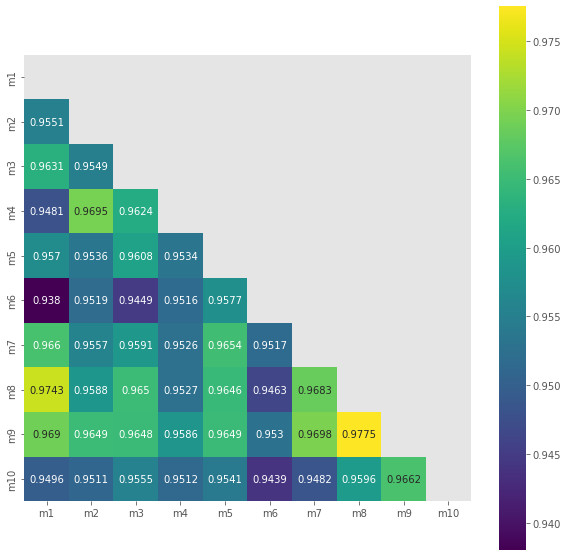

In [318]:
corr = oof_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

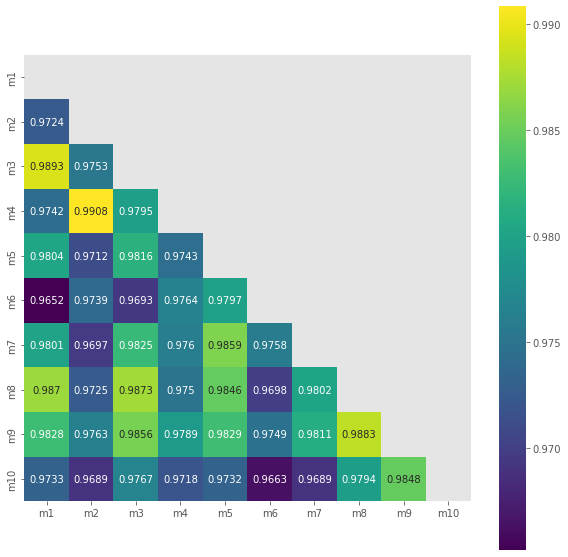

In [319]:
corr = test_probs.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [330]:
d = oof_predictions.shape[1]
stat_max = stats.gmean(oof_predictions, axis=1)
roc_max = roc_auc_score(y, stat_max)
while d > 4: 
    for subscores in combinations(oof_predictions.columns, r=d-1):
        stat = stats.gmean(oof_predictions[list(subscores)], axis=1)
        stat = roc_auc_score(y, stat)
        if stat > roc_max:
            roc_max = stat
            best_sub = list(subscores)
    d-=1
print(best_sub, roc_max)

['m4', 'm6', 'm9', 'm10'] 0.7345597091515608


In [290]:
mean_scores(oof_predictions, y)

AMean score: 0.73348
GMean score: 0.73353
Rank  score: 0.73334
GMean  rank: 0.73332


In [291]:
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',  # lsqr: same LB score
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda,
                                                             X=oof_predictions,
                                                             y=y,
                                                             cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.73264, Valid score = 0.74869
Fold 2, Train score: 0.73304, Valid score = 0.74500
Fold 3, Train score: 0.73427, Valid score = 0.73208
Fold 4, Train score: 0.73494, Valid score = 0.72719
Fold 5, Train score: 0.73345, Valid score = 0.73913
Fold 6, Train score: 0.73451, Valid score = 0.73139
Fold 7, Train score: 0.73325, Valid score = 0.74317
Fold 8, Train score: 0.73454, Valid score = 0.72966
Fold 9, Train score: 0.73484, Valid score = 0.72844
Fold 10, Train score: 0.73601, Valid score = 0.71734
Train score by each fold: [0.73264, 0.73304, 0.73427, 0.73494, 0.73345, 0.73451, 0.73325, 0.73454, 0.73484, 0.73601]
Valid score by each fold: [0.74869, 0.745, 0.73208, 0.72719, 0.73913, 0.73139, 0.74317, 0.72966, 0.72844, 0.71734]
Train mean score by each fold:0.73415 +/- 0.00098
Valid mean score by each fold:0.73421 +/- 0.00912
**************************************************


* Geometric mean by lda estimators

In [292]:
train_preds = np.array([estimator.predict_proba(oof_predictions)[:,1] for estimator in estimators_lda]).T
train_preds = stats.gmean(train_preds, axis=1)

# calculate_confidence_interval(create_bootstrap_metrics(y, train_preds, roc_auc_score))
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lda, roc_auc_score))

(0.728176832659636, 0.7389982852627472)

In [309]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_lda]).T
test_fin = pd.DataFrame(data=test_fin)
#test_fin = np.average(test_fin, axis=1)

test_fin = stats.gmean(test_fin, axis=1)

In [294]:
# 0.73420 on first 7 models. All models: 0.73346
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.92M [00:00<?, ?B/s]
  4%|4         | 216k/4.92M [00:00<00:03, 1.39MB/s]
 39%|###8      | 1.91M/4.92M [00:00<00:00, 4.60MB/s]
100%|##########| 4.92M/4.92M [00:02<00:00, 2.34MB/s]


* Geometric mean on test probabilities, obtained from base CV models

In [295]:
# 0.73393: on 7 models, 0.73375 - 10 models
test_fin = stats.gmean(test_probs, axis=1)
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.90M [00:00<?, ?B/s]
  5%|4         | 232k/4.90M [00:00<00:02, 1.68MB/s]
 26%|##6       | 1.28M/4.90M [00:00<00:00, 5.94MB/s]
 39%|###8      | 1.89M/4.90M [00:00<00:00, 3.27MB/s]
 71%|#######   | 3.45M/4.90M [00:00<00:00, 6.20MB/s]
100%|##########| 4.90M/4.90M [00:02<00:00, 2.42MB/s]


In [42]:
oof_total_scores = stats.gmean(oof_predictions, axis=1)
stability = create_bootstrap_metrics(y, oof_total_scores, roc_auc_score)

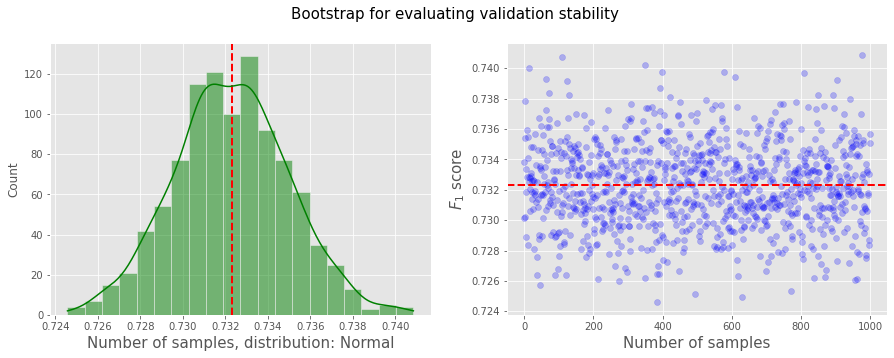

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(stability)), stability, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("$F_1$ score", size=15)
distribution = "Normal" if stats.shapiro(stability)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(stability), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(stability), lw=2, ls='--', c='red')
sns.histplot(stability, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()

In [46]:
# optimization with gmean: 0.73348

results_list = []   
weights_list = []  
preds = oof_predictions.values

def weights_objective(weights):
    # y_ens = np.average(preds, axis=1, weights=weights)
    y_ens = stats.gmean(preds, axis=1, weights=weights)
    return roc_auc_score(y, y_ens)

for k in range(100):
  
    w0 = np.random.uniform(size=preds.shape[1])
    bounds = [(0,1)] * preds.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.max(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))  # 0.73395 with gmean on test_scores


Optimized weights:
Best score: 0.7328


In [306]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

logreg = LogisticRegression(class_weight=None, 
                            solver='liblinear', 
                            penalty='l2', 
                            C=0.1, 
                            random_state=seed,
                            n_jobs=-1)

pipe = make_pipeline(PCA(n_components=6, random_state=seed), logreg)

estimators_log, oof_preds_log, mean_score_log = cross_validation(model=pipe,
                                                                 X=oof_predictions,
                                                                 y=y,
                                                                 cv=KFold(n_splits=10, shuffle=True, random_state=seed))

Fold 1, Train score: 0.73191, Valid score = 0.74978
Fold 2, Train score: 0.73238, Valid score = 0.74496
Fold 3, Train score: 0.73379, Valid score = 0.73150
Fold 4, Train score: 0.73427, Valid score = 0.72806
Fold 5, Train score: 0.73309, Valid score = 0.73806
Fold 6, Train score: 0.73405, Valid score = 0.73025
Fold 7, Train score: 0.73258, Valid score = 0.74257
Fold 8, Train score: 0.73410, Valid score = 0.72874
Fold 9, Train score: 0.73424, Valid score = 0.72739
Fold 10, Train score: 0.73536, Valid score = 0.71839
Train score by each fold: [0.73191, 0.73238, 0.73379, 0.73427, 0.73309, 0.73405, 0.73258, 0.7341, 0.73424, 0.73536]
Valid score by each fold: [0.74978, 0.74496, 0.7315, 0.72806, 0.73806, 0.73025, 0.74257, 0.72874, 0.72739, 0.71839]
Train mean score by each fold:0.73358 +/- 0.00100
Valid mean score by each fold:0.73397 +/- 0.00911
**************************************************


In [307]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_log]).T
test_fin = pd.DataFrame(data=test_fin)
test_fin = np.average(test_fin, axis=1)

In [308]:
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})  # 0.73397 on LB
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.88M [00:00<?, ?B/s]
  4%|4         | 216k/4.88M [00:00<00:02, 1.67MB/s]
 40%|####      | 1.96M/4.88M [00:00<00:00, 3.75MB/s]
100%|##########| 4.88M/4.88M [00:02<00:00, 2.46MB/s]


**Merge part 1 and part 2**

In [310]:
nonzero = pd.read_csv('nonzero.csv')
fin_sub = pd.DataFrame({ID_COL: test_index, TARGET: test_fin})

In [311]:
fin_sub = fin_sub.merge(nonzero, on=ID_COL, how='left')

In [312]:
# fin_sub[TARGET] = np.where(fin_sub['TARGET_y'].isna(), fin_sub['TARGET_x'], fin_sub['TARGET_y'])  # 0.73289

fin_sub[TARGET] = (fin_sub['TARGET_x'] * fin_sub['TARGET_y'])**(1/2)  # 0.73371
fin_sub.loc[fin_sub[TARGET].isna(), TARGET] = fin_sub.loc[fin_sub[TARGET].isna(), 'TARGET_x']

In [313]:
fin_sub.drop(['TARGET_y', 'TARGET_x'], axis=1, inplace=True)

In [364]:
fin_sub.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

400 - Bad Request



  0%|          | 0.00/4.92M [00:00<?, ?B/s]
  4%|4         | 208k/4.92M [00:00<00:03, 1.40MB/s]
 29%|##8       | 1.41M/4.92M [00:00<00:01, 2.74MB/s]
 39%|###8      | 1.91M/4.92M [00:00<00:00, 3.29MB/s]
 55%|#####5    | 2.71M/4.92M [00:00<00:00, 4.42MB/s]
 71%|#######1  | 3.50M/4.92M [00:00<00:00, 5.38MB/s]
 87%|########6 | 4.27M/4.92M [00:00<00:00, 6.08MB/s]
100%|##########| 4.92M/4.92M [00:02<00:00, 2.12MB/s]


## Appendix
### Feature selection

In [108]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [109]:
X_inspect = pd.concat([x_train, x_test], axis=0)
y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

inspector = LGBMClassifier(max_depth=4, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.05,   
                           random_seed=seed).fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=inspector,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5004


In [111]:
scores, deltas = calculate_permutation_importance(LGBMClassifier(**lgbm_params_my).fit(x_train, y_train), 
                                                  x_valid=x_test, 
                                                  y_valid=y_test,
                                                  probas=True, 
                                                  metric=roc_auc_score)

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:33<00:00,  3.51it/s]


In [116]:
perm = deltas[deltas >= 0].index.tolist()

In [133]:
perm = perm + ["EXTERNAL_SCORE_WEIGHTED", "EXTERNAL_SCORING_RATING_1"]

In [142]:
# select best feature set by exhaustive method
lgbm_params_my = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 1000,
                'learning_rate': 0.03,
                'num_leaves': 42,
                'max_depth': 10,
                'reg_alpha': 0.05,
                'reg_lambda': 0.06,
                'subsample': 0.8,
                'min_child_weight': 60,
                'random_state': seed
}

best_selector = BestSet(lgbm_params_my, k_features=40).fit(X[perm], y)

In [ ]:
max(best_selector.scores_), X[perm][list(best_selector.subsets_[np.argmax(best_selector.scores_)])]

In [153]:
X[perm].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])], max(best_selector.scores_)

(Index(['EXT_SCORES_mean', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'ANNUITY_JOB',
        'EXTERNAL_SCORING_RATING_3', 'NAME_CONTRACT_TYPE',
        'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'AMOUNT_ANNUITY',
        'EXTERNAL_SCORING_RATING_2', 'AGE', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_COUNT_AGE_INTERVAL',
        'EDUCATION_FAMILY_STATUS', 'TOTAL_SALARY_MEAN_AGE_INTERVAL',
        'AMOUNT_CREDIT', 'RATIO_AGE_TO_EXPERIENCE', 'RATIO_CAR_TO_AGE',
        'EXT_SCORES_min', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY',
        'AMOUNT_CREDIT_MEAN_AGE_INTERVAL',
        'AMOUNT_ANNUITY_MIN_BY_FAMILY_STATUS', 'RATIO_CREDIT_TO_AGE',
        'TOTAL_SALARY_MAX_AGE_INTERVAL', 'NEW_STATUS_MSeparated',
        'EXT_SCORE_3_ANNUITY', 'NEW_STATUS_MMarried',
        'TOTAL_SALARY_MEAN_BY_EDUCATION',
        'DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'CHILDRENS',
        'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'TOTAL_SAL

In [234]:
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.035,
    'num_leaves': 12,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 56,
    'random_state': seed
}

best_selector = BestSet(lgbm_params_my, k_features=20).fit(X[overall], y)

In [235]:
X[overall].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])], max(best_selector.scores_)

(Index(['NEW_CREDIT_TO_ANNUITY_RATIO', 'EXTERNAL_SCORING_RATING_3',
        'NAME_CONTRACT_TYPE', 'AMOUNT_ANNUITY', 'EXTERNAL_SCORING_RATING_2',
        'AGE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'RATIO_AMOUNT_ANNUITY_TO_SALARY',
        'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'RATIO_AGE_TO_EXPERIENCE',
        'RATIO_CAR_TO_AGE', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY',
        'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'GENDER',
        'AMOUNT_ANNUITY_MEAN_BY_FAMILY_STATUS', 'EXTERNAL_SCORE_WEIGHTED',
        'EXTERNAL_SCORING_RATING_1', 'BURO_CREDIT_TYPE_Credit card_MEAN',
        'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN'],
       dtype='object'),
 0.7336162564182418)

#### Watch profile features combinations (fillna before add, multiply, etc.) - new ipynb - did not work
#### target encoding did not work
#### adding history features did not work

### PART I 

Train CV ensemble models on existing profile data only with hold-out set, CI.

Combine part I and part II: replace samples scores, amean, gmean

did not work well

#### Train models without high error samples

### Optuna search

In [350]:
# tune lgbm
start_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'n_estimators': 2000,
                'reg_alpha': 0.436193,
                'reg_lambda': 0.479169,
                'subsample': 0.7,
                'min_split_gain': 0.024766,
                'min_child_weight': 56,
                'subsample_for_bin': 240000,
                'colsample_bytree': 0.508716,
                'is_unbalance': False,
                'random_state': seed
}


def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 4, 12),
                    'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 100),
                    'min_child_weight': trial.suggest_int('min_child_weight', 2, 300)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 X[exhaust], 
                                                 y, 
                                                 cv=fold, 
                                                 rounds=50,
                                                 verbose=False)
    
    
    return score
# LGBM: ex_overall+, boruta+, overall-, deltas-, boruta_bureau+, exhaust+
# XGB: ex_overall-
# CatBoost: boruta-, boruta_bureau-, exhaust-

In [352]:
%%time
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 1500
Best trial
Best score: 0.732934
Best params
{'learning_rate': 0.07698408707853092,
 'max_depth': 4,
 'min_child_weight': 103,
 'num_leaves': 13}
CPU times: total: 1d 17h 46min 33s
Wall time: 2h 46min 16s


In [ ]:
for subset in (overall, deltas):
    def objective(trial):
        param_trials = {
                        'max_depth': trial.suggest_int('max_depth', 4, 12),
                        'learning_rate': trial.suggest_float('learning_rate', 0.003, 0.3),
                        'num_leaves': trial.suggest_int('num_leaves', 6, 100),
                        'min_child_weight': trial.suggest_int('min_child_weight', 2, 300)
                        }

        param_trials.update(start_params)

        fold = KFold(n_splits=5, shuffle=True, random_state=seed)

        _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                     X[subset], 
                                                     y, 
                                                     cv=fold, 
                                                     rounds=50,
                                                     verbose=False)


        return score

    optuna.logging.set_verbosity(optuna.logging.FATAL)
    study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
    study.optimize(objective, n_trials=1500, timeout=10000)

    print(f'Number of completed trials: {len(study.trials)}')
    print('Best trial')
    trial = study.best_trial
    print(f'Best score: {trial.value}')
    print('Best params')
    pprint(trial.params)
    
start_params = {
                "objective": "binary:logistic",
                "booster": "gbtree",
                "eval_metric": "auc",
                "subsample": 0.85,
                "colsample_bytree": 0.7,
                "colsample_bylevel": 0.632,
                "alpha": 0.05,
                "lambda": 0.067,
                "random_state": seed,
                "n_jobs": -1
}
    
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 4, 12),
                    'eta': trial.suggest_float('eta', 0.003, 0.3),
                    'gamma': trial.suggest_float('gamma', 0, 25),
                    'min_child_weight': trial.suggest_int('min_child_weight', 2, 300)
                    }

    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)

    _, _, _, score = xgboost_cross_validation(param_trials, 
                                              X[ex_overall], 
                                              y, 
                                              cv=fold, 
                                              rounds=50,
                                              verbose=False,
                                              return_valid_mean=True)


    return score

optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=10000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)